In [14]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 10000 # encok kullanılan n kelmeyi kullan
maxlen = 100 #her yorumun uzunlugu

(x_train, y_train), (x_test,y_test) = imdb.load_data(num_words = max_features)

# yorumların uzunlaklarını 100 olacak sekilde ayarla
x_train = pad_sequences (x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

word_index = imdb.get_word_index() 

# kelime dizinin geri dondurmk için ters cevirelim 
reverse_word_index = {index+3: word for word, index in word_index.items() } # ters dizini
reverse_word_index[0] = "<PAD>" # PAD ile eslestir
reverse_word_index[1] = "<START>" 
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

# ornek metinleri yazdırma
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(word, "?") for word in encoded_review]) # her sayiyi kelimeyi cevir

random_indices = np.random.choice(len(x_train), size=3, replace = False) # rastgele 3 yorum sec
for i in random_indices:
    print(f"Yorum : {decode_review(x_train[i])},'\n'")
    print(f"etiket : {y_train[i]}")
    print()



Yorum : unfunny jokes and horrible comic situations it is like watching chris rock being chris rock not a character in a movie br br let's emphasize the <UNK> in down to earth mark <UNK> does not do any worse here than he did in the <UNK> in <UNK> rock vegas eugene levy and <UNK> <UNK> are well cast but they are at the mercy of a <UNK> script those are all the good qualities i can mention at this time and if you give me another week to <UNK> it is not likely that i will come up with any more,'
'
etiket : 0

Yorum : 1982 1 2 br br vintage <UNK> on the sword and <UNK> animated film which is only available via the washed out vhs print owned by ralph bakshi himself it goes into some detail about the <UNK> technique and also shows several instances of live action <UNK> in a studio of segments from the script which would then be <UNK> <UNK> in with the backgrounds and filmed still having watched several such behind the scenes <UNK> on the art of animation on the disney <UNK> and the looney t

In [21]:
# Transformers Blok

class TransformerBlock(layers.Layer):
    def __init__(self, embed_size, heads ,dropout_rate =0.3):
        super(TransformerBlock, self).__init__()

        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim = embed_size)
        self.norm1 = layers.LayerNormalization(epsilon = 1e-6)
        self.norm2 = layers.LayerNormalization(epsilon = 1e-6)

        self.feed_foward = models.Sequential([
            layers.Dense(embed_size*4, activation = "relu"),
            layers.Dense(embed_size)
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training):
        # dikkat (attention ) mekanizmasını uygulama
        attention = self.attention(x, x)
        x = self.norm1(x + self.dropout1(attention, training = training))
        feed_forward = self.feed_foward(x)
        return self.norm2(x + self.dropout2(feed_forward, training = training))
    
# Transformers Modeli

class TransformerModel(models.Model):
    def __init__(self, num_layers,embed_sizr, heads, input_dim, output_dim , dropout_rate = 0.3):
        super(TransformerModel, self).__init__()

        self.embedding = layers.Embedding(input_dim=input_dim, output_dim=embed_size)
        self.transformer_blocks = [TransformerBlock(embed_size, heads, dropout_rate) for _ in range(num_layers)]
        self.global_avg_pool = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(output_dim, activation = "sigmoid")

    def call(self, x, training):
        x = self.embedding(x)
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
            x = self.global_avg_pool(x)
            x = self.dropout(x, training=training)
            return self.fc(x)
        
# Modeli olusturma

num_layers = 4 
embed_size = 64
num_heads = 4
input_dim = max_features
output_dim = 1 # ikli sınuflafırma 1-0
dropout_rate = 0.1

model = TransformerModel(num_layers, embed_size, num_heads, input_dim, output_dim, dropout_rate)

model.build(input_shape = (None, maxlen))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()


c:\Users\mfurk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'transformer_model_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_model_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_36            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_37            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_38            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_39            │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# model egitimi 

history = model.fit(x_train, y_train, batch_size = 128, epochs = 4, validation_data = (x_test, y_test))

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - accuracy: 0.7001 - loss: 0.5509 - val_accuracy: 0.8387 - val_loss: 0.3655
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - accuracy: 0.8919 - loss: 0.2659 - val_accuracy: 0.8446 - val_loss: 0.3557
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - accuracy: 0.9223 - loss: 0.1998 - val_accuracy: 0.8375 - val_loss: 0.4046
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - accuracy: 0.9382 - loss: 0.1675 - val_accuracy: 0.8328 - val_loss: 0.4257


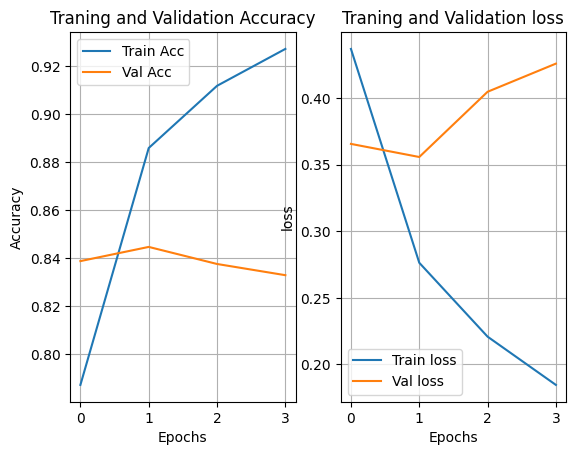

In [29]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Traning and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('True')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Traning and Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('True')

In [28]:
def predict_sentiment(model, text, word_index, maxlen):

    # metni imdb formatında sayıya çevir
    encoded_text = [word_index.get(word, 0) for word in text.lower().split()]
    padded_text = pad_sequences([encoded_text], maxlen=maxlen) # padding uygula
    prediction = model.predict(padded_text) # tahmin yap
    return prediction[0][0]

# kullanıcıdan yorum al
user_input = input("Yorum gir: ")
sentiment_score = predict_sentiment(model, user_input, word_index, maxlen)

if sentiment_score >= 0.5:
    print("olumsuz yorum")
else:
    print("olumlu yorum")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
olumsuz yorum
